<a href="https://colab.research.google.com/github/EliasMahiou/Seism/blob/main/examples/demo_seislm_visualized_pretrained_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q seisbench lightning ml-collections einops gdown wandb gitpython torchtune torchao

In [14]:
!pip uninstall numpy
!pip install numpy --upgrade --no-binary :all:

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/re

In [1]:
!pip install numpy==1.23.5


*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [3]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

In [4]:
import gdown
!git clone https://github.com/liutianlin0121/seisLM.git
%cd /content/seisLM

# Once cloned the repository, navigate to the root and install it with `pip install -e .`
!pip install -e .
import seisLM

fatal: destination path 'seisLM' already exists and is not an empty directory.
/content/seisLM
Obtaining file:///content/seisLM
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for seisLM (pyproject.toml) ... done
  Created wheel for seisLM: filename=seislm-0.1-0.editable-py3-none-any.whl size=3569 sha256=52cadc0e68c74153cc635eb4b83957d4c116b526696737ce60f9b48c42ac8e92
  Stored in directory: /tmp/pip-ephem-wheel-cache-hz7mbujo/wheels/e3/40/41/9e63f75c1fa47dc096706d3d2c6a5a1c104ff13c11ca9c691c
Successfully built seisLM
  Attempting uninstall: seisLM
    Found existing installation: seisLM 0.1
    Uninstalling seisLM-0.1:
      Successfully uninstalled seisLM-0.1


## Download the pretrained **SeisLM base** model


In [5]:
seisLM_base_ckpt_file_id = '12L2Js1DIXCIxacQJ4K0hRKJ6qHFrQ7K-'
seisLM_base_ckpt_destination = '/content/seisLM/results/models/pretrained_seislm_base/checkpoints/'
gdown.download(
    f'https://drive.google.com/uc?id={seisLM_base_ckpt_file_id}',
    seisLM_base_ckpt_destination,
    quiet=True
)


'/content/seisLM/results/models/pretrained_seislm_base/checkpoints/epoch=39-step=1203000.ckpt'

In [6]:
!wget --no-check-certificate "https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task1.csv?action=show" -O task1.csv


--2025-03-31 12:59:25--  https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task1.csv?action=show
Resolving dcache-demo.desy.de (dcache-demo.desy.de)... 131.169.191.70, 2001:638:700:10bf::1:46
Connecting to dcache-demo.desy.de (dcache-demo.desy.de)|131.169.191.70|:2443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4272225 (4.1M) [text/csv]
Saving to: ‘task1.csv’

task1.csv           100%[===================>]   4.07M  3.26MB/s    in 1.2s    

2025-03-31 12:59:27 (3.26 MB/s) - ‘task1.csv’ saved [4272225/4272225]



# Import packages

In [7]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seisbench.data as sbd
import seisbench.generate as sbg
import torch
import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from seisLM.data_pipeline.augmentations import FillMissingComponents


from seisLM.model.foundation.pretrained_models import (
  LitMultiDimWav2Vec2,
  MultiDimWav2Vec2ForPreTraining,
)
# from seisLM.utils import project_path


def check_gpu():
    if torch.cuda.is_available():
        print("✅ GPU is enabled for PyTorch.")
        print(f"🚀 GPU Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("❌ GPU is **not** enabled for PyTorch.")
        print("⚠️ To use a GPU, go to 'Runtime' > 'Change runtime type' and select 'GPU' as the hardware accelerator.")

check_gpu()

✅ GPU is enabled for PyTorch.
🚀 GPU Device Name: Tesla T4


SyntaxError: invalid syntax (<ipython-input-12-8697b7d7d20c>, line 1)

## Prepare dataloader

In [8]:
class MetaDataKeepingSteeredGenerator(sbg.SteeredGenerator):
  def _clean_state_dict(self, state_dict):
    # Remove control information
    trace_type = state_dict["_control_"]["trace_type"]
    X, meta = state_dict["X"]
    state_dict = {"X": X, "trace_type": trace_type}
    return state_dict


def get_loader():
  dataset_name = "ETHZ"
  task = "1"
  num_samples_per_trace_type = 1000

  dataset = sbd.__getattribute__(dataset_name)(
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    missing_component="copy",
    cache=None,
  )
  metadata_df = dataset.metadata

  eval_set = "dev"
  split = dataset.get_split(eval_set)

  # task_csv = f'/home/liu0003/Desktop/projects/seisLM/data/targets/{dataset_name}/task{task}.csv'
  task_csv = (
    "task1.csv"
  )

  task_targets = pd.read_csv(task_csv)
  task_targets = task_targets[task_targets["trace_split"] == eval_set]

  eq_targets = task_targets[task_targets["trace_type"] == "earthquake"].head(
    num_samples_per_trace_type
  )
  noise_targets = task_targets[task_targets["trace_type"] == "noise"].head(
    num_samples_per_trace_type
  )

  task_targets = pd.concat([eq_targets, noise_targets])

  generator = MetaDataKeepingSteeredGenerator(split, task_targets)
  generator.add_augmentations(
    [
      sbg.SteeredWindow(windowlen=3001, strategy="pad"),
      sbg.ChangeDtype(np.float32),
      sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
    ]
  )
  batch_size = 10
  num_workers = 2
  loader = DataLoader(
    generator,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
  )
  return loader


loader = get_loader()

2025-03-31 12:59:57,362 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2025-03-31 12:59:58,237 | seisbench | WARNING | Dataset ETHZ not in cache.
2025-03-31 12:59:58,239 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.


## Load pretrained model and its randomly initialized version

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_collections = {}

for model_type in ["pretrained", "random_init"]:
  model = LitMultiDimWav2Vec2.load_from_checkpoint(
    '/content/seisLM/results/models/pretrained_seislm_base/checkpoints/epoch=39-step=1203000.ckpt'
  ).model

  if model_type == "random_init":
    model = MultiDimWav2Vec2ForPreTraining(model.config)

  model = model.to(device)
  model = model.eval()
  model_collections[model_type] = model
  del model

## Extract embeddings of waveforms

In [10]:
embeddings_of_models = {}

for model_type, model in model_collections.items():
  batch_input_dict = defaultdict(list)
  batch_features_dict = defaultdict(list)

  for batch in tqdm.tqdm(loader):
    for key, value in batch.items():
      batch_input_dict[key].append(value)

    with torch.no_grad():
      input_values = batch["X"]
      wav2vec2_output = model.wav2vec2(
        input_values=input_values.cuda(),
        output_hidden_states=True,
      )

    batch_features_dict["conv_features"].append(
      wav2vec2_output.extract_features.mean(axis=1)
    )

    for hidden_states_layer_idx, hidden_states in enumerate(
      wav2vec2_output.hidden_states
    ):
      batch_features_dict[f"hidden_states_{hidden_states_layer_idx}"].append(
        hidden_states.mean(axis=1)
      )

  all_features_dict = defaultdict(list)
  all_input_values = defaultdict(list)

  for key, value in batch_features_dict.items():
    concat_features = torch.concatenate(value, axis=0).cpu().numpy()
    all_features_dict[key] = concat_features

  for key, value in batch_input_dict.items():
    if isinstance(value[0], torch.Tensor):
      concat_values = torch.cat(value, axis=0).cpu().numpy()
    elif isinstance(value[0], np.ndarray) or isinstance(value[0], list):
      concat_values = np.concatenate(value, axis=0)
    else:
      raise ValueError
    all_input_values[key] = concat_values

  embedding_dict = defaultdict(list)

  for key, value in tqdm.tqdm(all_features_dict.items()):
    # pca = PCA(n_components=2)
    # embedding_dict[key] = pca.fit_transform(value)

    tsne = TSNE(
      n_components=2,
      max_iter=500,
      n_iter_without_progress=150,
      n_jobs=2,
      random_state=0,
    )

    embedding = tsne.fit_transform(value)
    embedding_dict[key] = embedding

  embeddings_of_models[model_type] = embedding_dict

100%|██████████| 8/8 [00:58<00:00,  7.30s/it]


## Visualize the result

position key, hidden_states_6


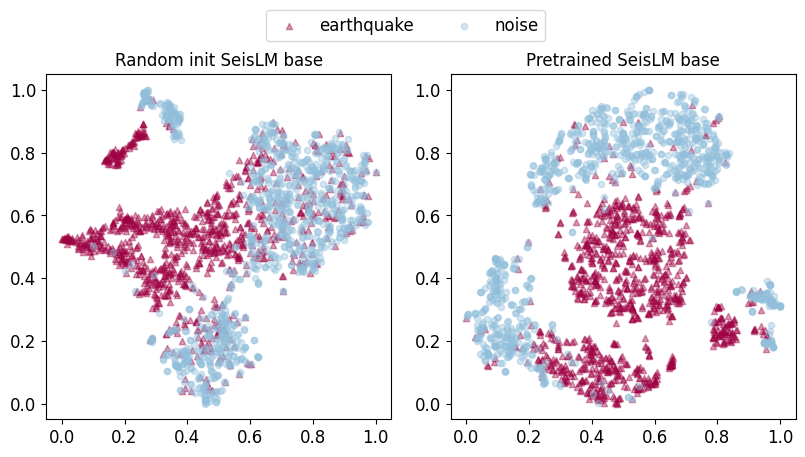

In [13]:
import numpy as np

all_trace_types = all_input_values["trace_type"]
# Configuration and constants
markers = {"noise": "o", "earthquake": "^"}
a4_width = 8.27
fig_width = a4_width
fig_height = fig_width / 2
marker_size = 20
show_all_trace_indices = False
trace_indices = [1600, 1400, 600, 0]

# Create figure with two subplots side by side
fig, (ax_col1, ax_col2) = plt.subplots(1, 2, figsize=(fig_width, fig_height))

FONT_SIZE = 12
# Create figure with two subplots side by side
plt.rcParams.update(
  {
    "font.size": FONT_SIZE,  # General font size
    "axes.titlesize": FONT_SIZE,  # Subplot titles
    "figure.titlesize": FONT_SIZE,  # Suptitle (main title)
    "legend.fontsize": FONT_SIZE,  # Legend font size
    "pdf.fonttype": 42,  # Embed fonts in PDF for better compatibility
  }
)


def plot_embeddings(ax, embeddings, trace_type, label, color, marker):
  embedding_of_label = embeddings[np.array(label) == trace_type]
  ax.scatter(
    *embedding_of_label.T,
    label=label,
    marker=marker,
    s=marker_size,
    c=color,
    alpha=0.4,
    zorder=2,
  )

  if show_all_trace_indices:
    label_indices = np.where(np.array(label) == trace_type)[0]
    embedding_of_label = embeddings[label_indices]
    dot_indices = np.arange(len(embedding_of_label))[::200]
    for dot_index in dot_indices:
      x, y = embedding_of_label[dot_index]
      ax.text(x, y, str(label_indices[dot_index]), fontsize=8, ha="right")


def annotate_traces(ax, embeddings, trace_indices):
  for trace_index in trace_indices:
    x, y = embeddings[trace_index]
    ax.text(
      x,
      y,
      str(trace_index),
      fontsize=12,
      ha="right",
      bbox=dict(facecolor="#e0e0e0", edgecolor="none", pad=1),
    )


# Plot for random_init in the first subplot

position_key = list(embeddings_of_models["random_init"])[-1]
print(f"position key, {position_key}")
embeddings_random = MinMaxScaler().fit_transform(
  embeddings_of_models["random_init"][position_key]
)

for label, color in zip(["earthquake", "noise"], ["#9e0142", "#91bfdb"]):
  plot_embeddings(
    ax_col1, embeddings_random, all_trace_types, label, color, markers[label]
  )
# annotate_traces(ax_col1, embeddings_random, trace_indices)
# ax_col1.legend()
ax_col1.set_aspect("equal")  # Ensure the scatter plot is square
ax_col1.set_title("Random init SeisLM base")

# Plot for pretrained in the second subplot
embeddings_pretrained = MinMaxScaler().fit_transform(
  embeddings_of_models["pretrained"][position_key]
)
for label, color in zip(["earthquake", "noise"], ["#9e0142", "#91bfdb"]):
  plot_embeddings(
    ax_col2,
    embeddings_pretrained,
    all_trace_types,
    label,
    color,
    markers[label],
  )
# annotate_traces(ax_col2, embeddings_pretrained, trace_indices)
# ax_col2.legend()
ax_col2.set_aspect("equal")  # Ensure the scatter plot is square
ax_col2.set_title("Pretrained SeisLM base")

# Adjust layout for better spacing
plt.tight_layout()

# plt.subplots_adjust(wspace=0.3)  # Adjust wspace to control the space between plots
handles, labels = ax_col1.get_legend_handles_labels()
fig.legend(
  handles,
  labels,
  loc="upper center",
  ncol=len(labels),
  bbox_to_anchor=(0.5, 1.1),
  frameon=True,
)

plt.show()
